# Important note before running this code
This code assumes that the data preperation notebook was executed before and hence the sql database accessed underneath, is already populated

In [4]:
# Imports
from sqlalchemy import create_engine, inspect, Table
import pandas as pd
import numpy as np
import json
import country_converter as coco
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from datetime import datetime

In [5]:
# Open a connection to the postgresql database
db_conn = create_engine("postgresql://student:infomdss@db_dashboard:5432/covid")

In [6]:
print(pd.read_sql('SELECT * FROM cases',db_conn))

     iso_code       date  new_cases_per_million  \
0         JPN 2020-01-22                    NaN   
1         JPN 2020-01-23                  0.000   
2         JPN 2020-01-24                  0.000   
3         JPN 2020-01-25                  0.000   
4         JPN 2020-01-26                  0.016   
...       ...        ...                    ...   
2974      JPN 2022-10-24                135.235   
2975      NLD 2022-10-24                  0.800   
2976      ITA 2022-10-25                822.295   
2977      JPN 2022-10-25                382.835   
2978      NLD 2022-10-25                606.456   

      new_cases_smoothed_per_million  reproduction_rate  
0                                NaN                NaN  
1                                NaN                NaN  
2                                NaN                NaN  
3                                NaN                NaN  
4                                NaN                NaN  
...                              ...   

In [7]:
class SQL_reader:
    def __init__(self, db_conn,mainView,ISO_filter = ['NLD','JPN','ITA']):
        self.db_conn = db_conn
        self.mainView = mainView
        self.ISO_filter = ISO_filter
    def GetIsoDict(self, kpiColNames, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method to load desired data in a dictionary with country iso codes as keys
        In: 
            kpiColNames: a list of the column names of the kpis which are to be extracted
            policyColName: the column name of the policy measure which is to be extracted 
            daysAhead: the number of days that should be between the values in the kpi lists and the corresponding future policy measure levels.
            Ultimatly this will be the number of days the analysis will look into the future.
        Out: 
            a dictionary with iso_code as key and a three-element tuple as value. Elements of the tuple:
                kpis: A list of list, 1 list for all values for the desired kpis (given in the kpiColNames-list). These lists contain all values for the given kpi and iso code specified in
                the dictionary key.
                futPolicy: a list of the chosen policy measure (standardly the PER level) N days after the same entry in the kpi-lists, where N is daysAhead
                indices: a list of original indices within the SQL table of all entries in the kpi lists.
        
        """
        isoDict = dict()
        for iso in self.ISO_filter:
            queryP2 = ' FROM ' + self.mainView + '\nWHERE ' "iso_code = '" + iso + "';"
            futPolicy = np.array(pd.read_sql('SELECT ' + policyColName + queryP2, self.db_conn)[policyColName])
            futPolicy = futPolicy[daysAhead:]
            indices = np.array(pd.read_sql('SELECT index' + queryP2, self.db_conn)['index'])
            indices = indices[:-daysAhead]
            kpis = []
            for kpiColName in kpiColNames:
                kpi = np.array(pd.read_sql('SELECT ' + kpiColName + queryP2, self.db_conn)[kpiColName])
                kpi = kpi[:-daysAhead]
                kpis.append(kpi)
            toDelete = []

            for i in range(len(futPolicy)):
                if futPolicy[i] == None or np.isnan(futPolicy[i]): #Ugly code, first  condition should be dropped after data preprocessing makes sure missing values are encoded consistentl
                    toDelete.append(i)
                    continue
                for kpi in kpis:
                    if kpi[i] == None or np.isnan(kpi[i]): #Ugly code, first  condition should be dropped after data preprocessing makes sure missing values are encoded consistently
                        toDelete.append(i)
                        break
            for i in range(len(kpis)):
                kpis[i] = np.delete(kpis[i],toDelete)
            futPolicy = np.delete(futPolicy,toDelete)
            indices = np.delete(indices,toDelete)
            isoDict[iso] = (kpis,futPolicy,indices)
        return isoDict
    
    def FormatColumns(self, kpiColNames, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method to load desired data of all used countries into a single list
        In: 
            kpiColNames: a list of the column names of the kpis which are to be extracted
            policyColName: the column name of the policy measure which is to be extracted 
            daysAhead: the number of days that should be between the values in the kpi lists and the corresponding future policy measure levels.
            Ultimatly this will be the number of days the analysis will look into the future.
        Out: 
            a three tuple. Elements of the tuple:
                kpis: A list of list, 1 list for all values for the desired kpis (given in the kpiColNames-list). These lists contain all values for the given kpi and iso code specified in
                the dictionary key.
                futPolicy: a list of the chosen policy measure (standardly the PER level) N days after the same entry in the kpi-lists, where N is daysAhead
                indices: a list of original indices within the SQL table of all entries in the kpi lists.
        
        """
        isoDict = self.GetIsoDict(kpiColNames,policyColName,daysAhead)
        
        kpis = []
        for i in range(len(list(isoDict.values())[0][0])):
            kpis.append([])
        policy = []
        indices = []
        for k, v in isoDict.items():
            kpiParts, policyPart, indicesPart = v
            for i in range(len(kpiParts)):
                kpis[i].extend(kpiParts[i])
            policy.extend(policyPart)
            indices.extend(indicesPart)
        return (kpis, policy,indices)
    
    def FindRecordsFromKPIs(self, kpiNames,kpiValues):
        """
        A function that returns a dataframe with the possible records of a partially known instance based on a list of known kpi values for this instance.
        In: 
            kpiNames: a list of the names of the kpis of which the value is known for the instance
            kpiValues: a list of the values of these kpis
        Out: 
            A pandas dataframe consisting of all possible records the instance might correspond to based on the kpi values.
        """
        query = 'SELECT * FROM ' + self.mainView + ' WHERE '
        for i in range(len(kpiNames)):
            query += kpiNames[i]+" = " + str(kpiValues[i]) + ' AND '
        if len(kpiNames) > 1:
            query = query[:-5]
        return pd.read_sql(query, self.db_conn)
    
    def FindRecordFromDateAndISO(self, date, ISO):
        """
        A function that returns the unique entry in the SQL database identified by a given date (date) and the iso_code of a country (ISO).
        The resulted record will be a pandas dataframe.
        """
        query = 'SELECT * FROM ' + self.mainView + " WHERE date = CAST('" + str(date) + "' AS DATE) AND iso_code = '" + ISO +"';"
        return pd.read_sql(query, self.db_conn)
    
    def FindRecordFromIndex(self, index):
        """
        A function that returns the unique entry in the SQL database identified by a given index.
        The resulted record will be a pandas dataframe.
        """
        query = 'SELECT * FROM '+ self.mainView + ' WHERE index = ' + str(index)
        return pd.read_sql(query, self.db_conn)


In [8]:
sql_reader = SQL_reader(db_conn,'all_relevant')

In [9]:
class DescriptiveRelationAnalytics:
    """
    A class designed to perform descriptive analytics for the relation between
    all kpi's and our independent variable, being the public event restrictions (PER) level
    in place (an ordinal value with 5 levels).
    """
    def __init__(self, sql_reader):
        self.sql = sql_reader
    def KPI_policy_covar(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to find and return the covariance matrix between a given kpi and the PER level X days later,
        where X = daysAhead
        NOTE TO SELF: covariance between an ordinal and ratio value might not make sense, might need to delete this function
        """
        kpis, policy,_ = self.sql.FormatColumns([kpiColName],policyColName,daysAhead)
        kpi = kpis[0]
        covar = np.cov(kpi,policy)
        return covar
    def KPI_policy_rho(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to find and return Spearman's rank correlation coefficient, denoted as rho, 
        together with the corresponding p-value between given KPI measure and the PER level X days later, where X = daysAhead.
        """
        kpis, policy,_ = self.sql.FormatColumns([kpiColName],policyColName,daysAhead)
        kpi = kpis[0]
        rho, p = spearmanr(kpi,policy)
        return (rho,p)
    
    def KPI_policy_plot(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to plot the PER level against a given kpi X days earlier, where X = daysAhead, distinguishing between different countries.
        """
        isoDict = self.sql.GetIsoDict([kpiColName],policyColName,daysAhead)
        for iso, v in isoDict.items():
            kpis, policy, _ = v
            kpi = kpis[0]
            plt.scatter(kpi,policy, marker = '.',alpha=0.2)
        plt.xlabel(kpiColName)
        plt.ylabel(policyColName)
        title = policyColName + ' for ' + kpiColName + ' ' + str(daysAhead) +' days before in '
        if len(self.sql.ISO_filter)==1:
            title += self.sql.ISO_filter[0]
        else:
            for iso in self.sql.ISO_filter[:-1]:
                title+= iso + ', '
            title = title[:-2]
            title += ' and ' + self.sql.ISO_filter[-1]
        plt.title(title)
        leg = [x + ' (N=' + str(len(isoDict[x][0][0])) + ')' for x in isoDict.keys()]
        plt.legend(leg, bbox_to_anchor=(1,1), loc="upper left")
        plt.yticks(np.arange(5),['No restrictions','> 1000 people','100-1000 people','10-100 people','< 10 people'])
        plt.show()

    def KPIs_policy_stats_and_plots(self, kpiColNameList, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which provides and prints statistical data on the relation between a given list of KPIs and the PER level X days later, where X = daysAhead
        and plots their relation as well
        """
        for kpiName in kpiColNameList:
            print(kpiName)
            print('covariation:\n'+str(self.KPI_policy_covar(kpiName,policyColName,daysAhead)))
            rho, p = self.KPI_policy_rho(kpiName,policyColName,daysAhead)
            print('Pearson Rho: ' + str(rho) +'\t' + 'p: ' + str(p))
            self.KPI_policy_plot(kpiName,policyColName,daysAhead)
 
    
    

In [10]:
DRanalytics = DescriptiveRelationAnalytics(sql_reader)

In [11]:
DRanalytics.KPI_policy_rho('reproduction_rate')

(0.06907641167614767, 0.0002343529508378429)

In [13]:
kpis = ['new_cases_smoothed_per_million','reproduction_rate','icu_patients_per_million','hosp_patients_per_million','weekly_icu_admissions_per_million',
        'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred','new_vaccinations_smoothed_per_million']
#kpis = [s+'_inter' for s in kpis]

new_cases_smoothed_per_million
covariation:
[[ 4.70761658e+05 -8.28950289e+01]
 [-8.28950289e+01  2.61348603e+00]]
Pearson Rho: 0.10908595414960313	p: 4.4346438587972986e-09


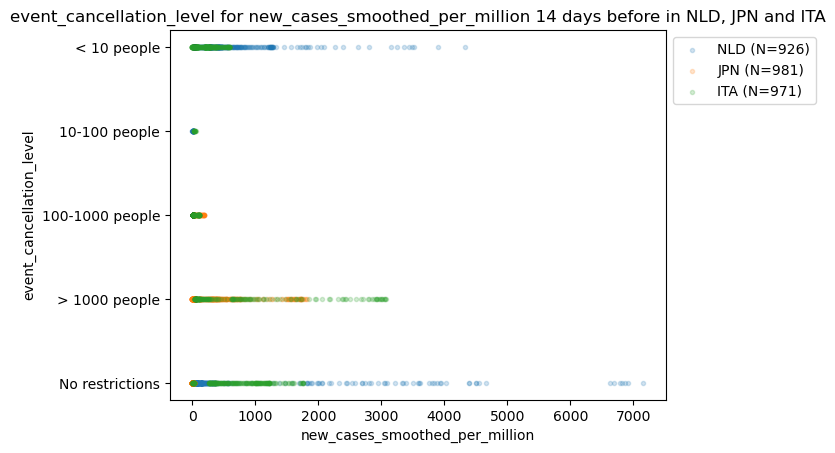

reproduction_rate
covariation:
[[0.14874296 0.04918053]
 [0.04918053 2.5966747 ]]
Pearson Rho: 0.06907641167614767	p: 0.0002343529508378429


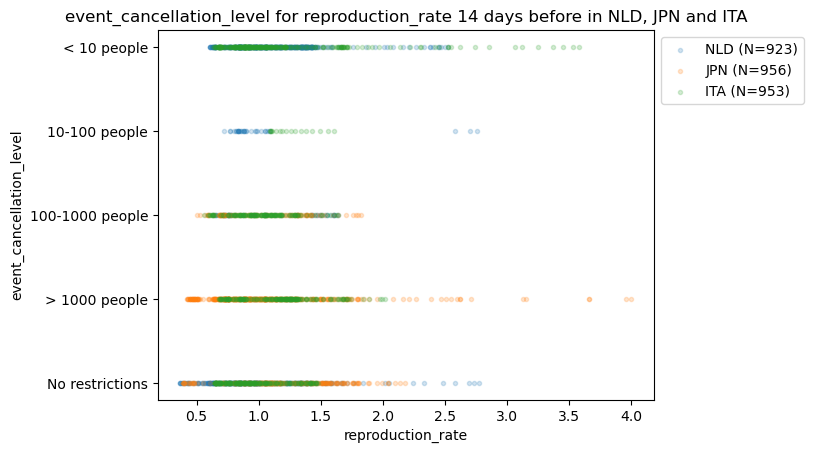

icu_patients_per_million
covariation:
[[322.02034507  19.33391112]
 [ 19.33391112   2.99446258]]
Pearson Rho: 0.5685001443380053	p: 4.0842391626322874e-168


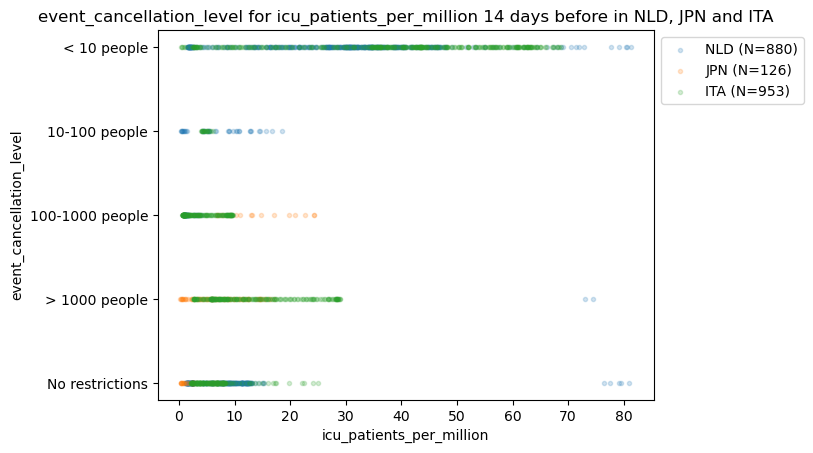

hosp_patients_per_million
covariation:
[[2.03096527e+04 7.97230107e+01]
 [7.97230107e+01 2.99521596e+00]]
Pearson Rho: 0.24349560703867756	p: 7.57145998149753e-28


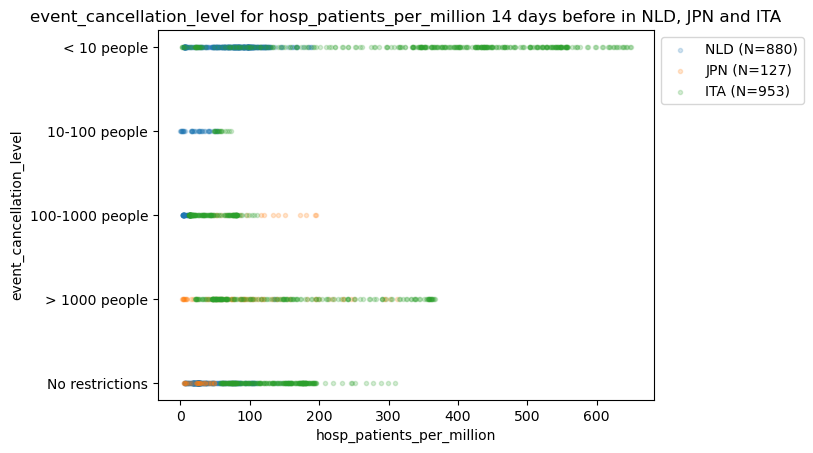

weekly_icu_admissions_per_million
covariation:
[[50.10971941  9.13784253]
 [ 9.13784253  3.35095386]]
Pearson Rho: 0.675758391345154	p: 5.184108912867146e-174


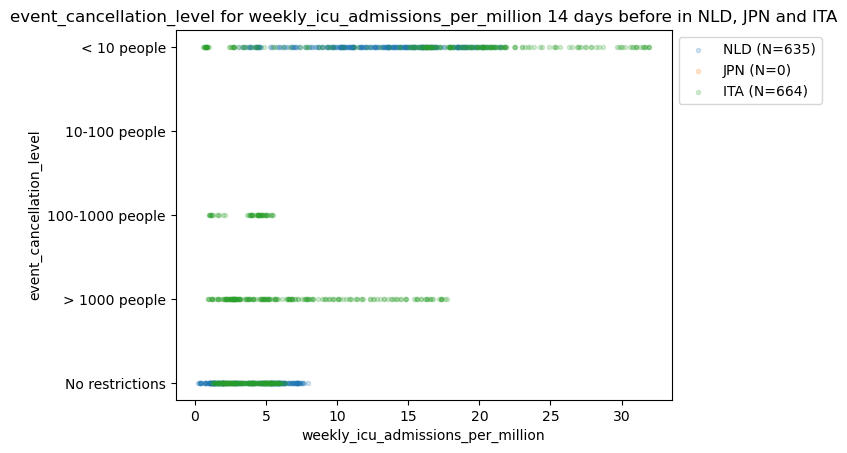

people_fully_vaccinated_per_hundred
covariation:
[[940.04592595 -28.40272374]
 [-28.40272374   1.62706765]]
Pearson Rho: -0.650752571695965	p: 1.2497343814930715e-155


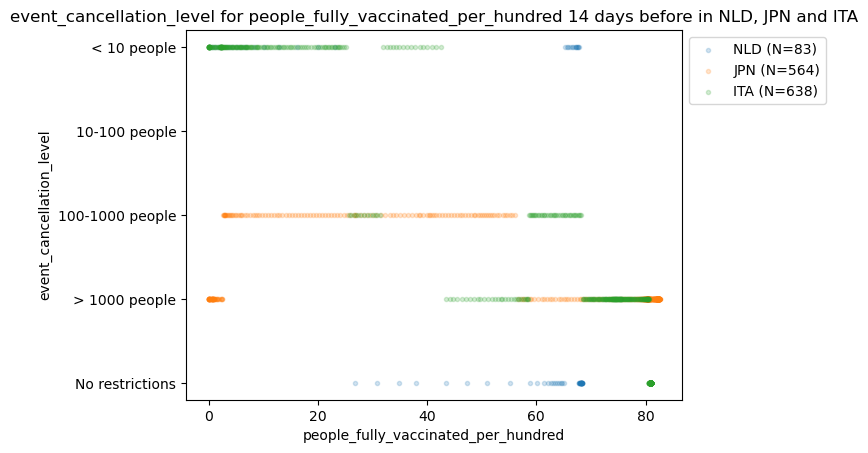

total_boosters_per_hundred
covariation:
[[ 8.28810745e+02 -8.07118173e+00]
 [-8.07118173e+00  4.29651778e-01]]
Pearson Rho: -0.5114503592003107	p: 1.0683021694804904e-50


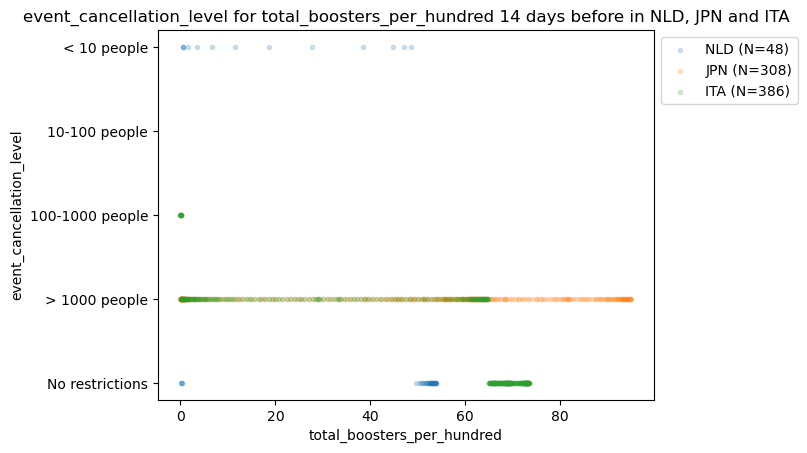

new_vaccinations_smoothed_per_million
covariation:
[[1.27833866e+07 1.59792498e+03]
 [1.59792498e+03 2.26862159e+00]]
Pearson Rho: 0.4610575610893934	p: 1.6665031725100484e-97


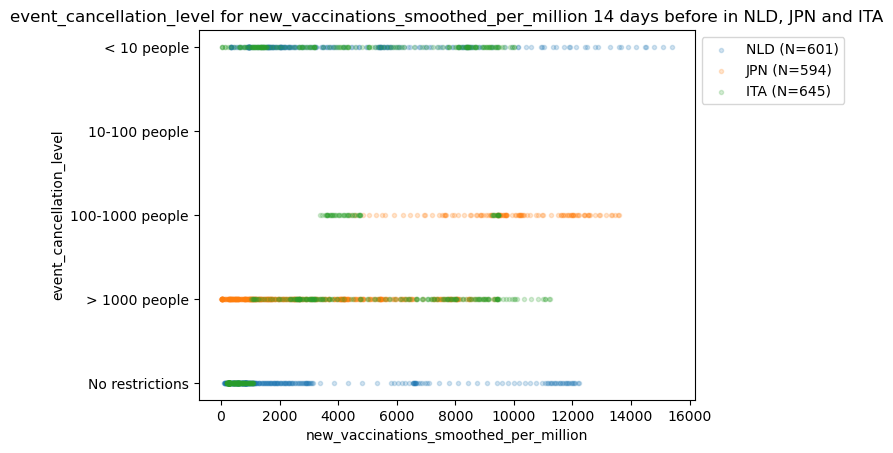

In [14]:

DRanalytics.KPIs_policy_stats_and_plots(kpis)

# Towards predictive analytics

In [15]:
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import train_test_split

In [16]:
class ML:
    """
    A class which contains functions that are helpful in using ML models in predictive analysis.
    """
    def score(model, X, Y):
        """
        A method to calculate and return the accuracy score of a given model (model) on a given feature matrix of size #samples X #features and 
        a correct answer array of size #samples.
        """
        right = 0
        Y_hat = model.predict(X)
        for i in range(len(Y)):
            if Y_hat[i] == Y[i]:
                right += 1
        return right/len(Y)

In [17]:
class MajorityBaseline:
    """
    A class to make, train, use and evaluate a baseline classifier simply returning the most frequent y label for each x input.
    """
    def __init__(self):
        self.choice = 0
    def fit(self,X,Y):
        N = len(np.unique(Y))
        Count = []
        for i in range(N):
            Count.append(0)
        for y in Y:
            for i in range(N):
                if y == i:
                    Count[i] += 1
                    break
        maxCount = max(Count)
        print(Count)
        print(maxCount)
        self.choice = [i for i in range(len(Count)) if Count[i]==maxCount][0]
    def predict(self, X):
        return np.array([self.choice for x in X])
    def score(self, X, Y):
        return ML.score(self, X, Y)

In [18]:
class KClosestNeighborsBaseline:
    """
    A class to make, train, use and evaluate a baseline classifier simply returning the most frequent y label among the k
    instances in X closest to a given x. In this context close is not the same as near, so this is not a K nearest neighbor model.
    Instead with x1 and x2 being close I mean that in the original dataset X (containing both testing and training data) they were close so X[i+1] and X[i-1] would be closest
    to any X[i]. Because our training data is ordered by country and within single countries order by date, close data points usualy represent
    data from the same time period and the same country (the only exception being datapoints at the strart and end of each country section in the data).
    
    Because close datapoints are likely to be similair both in x-features (kpis) a KNN algorithm is likely to select these as nearest neighbors and because
    these close datapoints also tend to have the same y-labels (PER) levels, the KNN algorithm is likely to be correct. Hence this KCN algorithm can help
    determining whether high KNN accuracy is a result of near neighbors being close neighbors being similair in y labels (this is not what we would desire) or 
    whether high KNN accuracy show a direct relation between x-features and y-labels.
    
    NOTE: because this algorithm takes the position of x in X into account it only works as a baseline for accuracy testing in a complete dataset X. 
    It does not work for predicting y for any new x outside of X.
    """
    def __init__(self, k, X_complete,Y_complete):
        """
        This model requires access to the complete dataset including both testing and training data (see the class description)
        """
        self.k = k
        self.X = X_complete
        self.Y = Y_complete
    def fit(self,X,Y):
        """
        This model doesn't have to be trained.
        """
        return
    def predict(self, X):
        """
        For each x to be predicted returns the closest x' in X.
        See class description for an explaination of closeness.
        """
        Y = []
        for x in X:
            Y.append(self.__predict_single_item(x))
        return np.array(Y)
    def __predict_single_item(self, x):
        """
        returns the closets x' in X to given x.
        See class description for an explaination of closeness.
        """
        ix = [i for i in range(len(self.X)) if np.array_equal(self.X[i],x)][0]
        i = 1
        nbs = []
        while len(nbs) < self.k:
            if ix + i < len(self.X):
                nbs.append(ix+i)
            if len(nbs) < self.k and ix-i >= 0:
                nbs.append(ix-i)
            i += 1
        Ynbh = [self.Y[i] for i in nbs]
        freqDict = dict()
        for y in np.unique(Ynbh):
            freqDict[y] = 0
        for y in Ynbh:
            freqDict[y] += 1
        maxFreq = max(list(freqDict.values()))
        return [y for y in freqDict.keys() if freqDict[y]==maxFreq][0]
    def score(self, X, Y):
        return ML.score(self, X, Y)

In [19]:
class PredictiveAnalytics:
    def __init__(self, sql_reader,selectedKPIs, policyColName = 'event_cancellation_level', daysAhead = 14):
        
        self.sql = sql_reader
        self.KPIs = selectedKPIs
        X, Y, indices = self.sql.FormatColumns(self.KPIs,policyColName,daysAhead)
        X =np.array(X)
        Y = np.array(Y)
        
        M = []
        S = []
        for x in X:
            M.append([np.mean(x)])
            S.append([np.std(x,ddof=1)])
        M = np.array(M)
        S = np.array(S)
        X = ((X - M)/S+1)/2
        X=X.T

        self.M=M
        self.S=S
        self.X = X
        self.Y = Y
        self.Indices = indices
        
    def NormalizeCostumX(self,X):
        X = ((X - self.M)/self.S+1)/2
        return X.T
        
    def getMeanAndSD(kpi):
        m = np.mean(kpi)
        s = np.std(kpi,ddof=1)
        return m,s
    
    def PredictKNN(self, X, k = 5):
        knn = KNC(n_neighbors = k)
        knn.fit(self.X, self.Y)
        return knn.predict(X)
    
    def TestModels(self, modelDict):
        # Split into training and test set
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size = 0.2, random_state=42)
        scoreDict = dict()
        for key, value in modelDict.items():
            value.fit(X_train, Y_train)
            scoreDict[key] = value.score(X_test,Y_test)
        return scoreDict
    
    def GetSQLIndicesOfx(self, x):
        res = [self.Indices[i] for i in range(len(self.Indices)) if X[i] == x]
        return res
    
    def GetSQLIndexFromInternalIndex(self, index):
        return self.Indices[index]
    



In [20]:
selectedKPIs = [ x for x in kpis if x not in ['weekly_icu_admissions_per_million']]

PrAn = PredictiveAnalytics(sql_reader,selectedKPIs)

In [21]:
N = [0,0,0,0,0]
for y in PrAn.Y:
    for i in range(5):
        if y == i:
            N[i] += 1
            break
print('Y data distribution:')
for i in range(5):
    print(str(i) + ': ' + str(N[i]))

Y data distribution:
0: 235
1: 218
2: 12
3: 0
4: 13


In [22]:

modelDict = dict()
modelDict['knn model (k=1)'] =  KNC(n_neighbors = 1)
modelDict['knn model (k=2)'] =  KNC(n_neighbors = 2)
modelDict['knn model (k=5)'] = KNC(n_neighbors = 5)
modelDict['kcn baseline (k=1)'] = KClosestNeighborsBaseline(1,PrAn.X,PrAn.Y)
modelDict['kcn baseline (k=5)'] = KClosestNeighborsBaseline(5,PrAn.X,PrAn.Y)
modelDict['kcn baseline (k=10)'] = KClosestNeighborsBaseline(10,PrAn.X,PrAn.Y)
mb = MajorityBaseline()
modelDict['Majority baseline'] = mb
x = PrAn.TestModels(modelDict)
print(x)

[186, 176, 10, 0]
186
{'knn model (k=1)': 0.9895833333333334, 'knn model (k=2)': 0.90625, 'knn model (k=5)': 0.90625, 'kcn baseline (k=1)': 0.9895833333333334, 'kcn baseline (k=5)': 0.9895833333333334, 'kcn baseline (k=10)': 0.9791666666666666, 'Majority baseline': 0.5104166666666666}


In [23]:
print(PrAn.Indices[250])

102372


In [24]:
test = sql_reader.FindRecordFromDateAndISO('2022-04-19','ITA')[selectedKPIs]
Xtest = np.array([[test[s][0]] for s in selectedKPIs])
print(Xtest)
Xtest = PrAn.NormalizeCostumX(Xtest)

knn1 = KNC(n_neighbors = 5)
knn1.fit([x for x in PrAn.X if not np.array_equal(x,Xtest)], [PrAn.Y[i] for i in range(len(PrAn.X)) if not np.array_equal(PrAn.X[i],Xtest)])
dist, ind = knn1.kneighbors(Xtest)
print('Most similair historical examples:')
for i in range(dist.shape[1]):
    neigh = sql_reader.FindRecordFromIndex(PrAn.GetSQLIndexFromInternalIndex(ind[0,i]))
    date = neigh['date'][0].strftime('%Y-%m-%d')
    country = neigh['location'][0]
    PER = neigh['event_cancellation_level'][0]
    print(country, date + '. This situation resulted in a PER level of', str(int(PER)) + '.')

[[851.719]
 [  0.94 ]
 [  7.124]
 [179.54 ]
 [ 80.81 ]
 [ 66.32 ]
 [390.   ]]
Most similair historical examples:
Italy 2022-04-19. This situation resulted in a PER level of 0.
Italy 2022-04-18. This situation resulted in a PER level of 0.
Italy 2022-04-29. This situation resulted in a PER level of 0.
Italy 2022-04-16. This situation resulted in a PER level of 0.
Italy 2022-04-30. This situation resulted in a PER level of 0.


In [25]:
mb.choice

0